# Movie recommendation system
Recommender Systems are widely used these days, you can find them anywhere.
For example, say you were watching a netflix movie and the movie finishes, netflix will recommend for you to watch another movies that are related to what you were watching.


# Dataset [MovieLens]

 **MovieLens** 100K dataset.  

- This dataset consists of :
  - 100,000 ratings (1-5) from 943 users on 1682 movies
  - Each user has rated at least 20 movies


The data can be obtained from the **MovieLens** website
https://grouplens.org/datasets/movielens/100k

# Libraries Used in this project:
 - Pandas for the dataframe analysis
 - NumPy for the complicated operations and calculations
 - SeaBorn for the plotting
 - SkLearn for model generation and evaluation


# Bullet points
In this project, we'll cover two main techniques for recommender system construction
 - Content-based filtering
   - it uses the features and the description of the item to recommend items that are similar to the features and the description.
 - Collaborative filtering
   - it uses the similarities between users and items to provide recommendations


# Data Exploration
 - in this section, we will read the data and analyze it to see what we have.
  

In [1]:
# Importing the libraries we'll use in the project.


# Since sklearn has importing issues, this explicit import to avoid error.
!pip install sklearn 

from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# This dataset has the following:
# - 100,000 ratings (1-5) from 943 users on 1682 movies
ratings = pd.read_csv('ratings.csv')

# Movies dataset
movies = pd.read_csv('movies.csv')

In [3]:
# Starting with the movies dataset.
display(movies.info()) # displays general info about the data.
display(movies.sample(10)) # displays 10 random rows from the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

,movieId,title,genres
374,430,Calendar Girl (1993),Comedy|Drama
6264,47261,"Night Listener, The (2006)",Fantasy|Mystery|Thriller
9073,142509,Hardcore Henry (2015),Action|Adventure|Sci-Fi
1666,2241,Class (1983),Comedy
8197,103245,Adam and Eve (National Lampoon's Adam & Eve) (...,Comedy|Drama|Romance
7848,93598,"Snowtown (Snowtown Murders, The) (2011)",Crime|Drama|Thriller
3460,4719,Osmosis Jones (2001),Action|Animation|Comedy|Crime|Drama|Romance|Th...
1710,2298,Strangeland (1998),Thriller
2390,3171,Room at the Top (1959),Drama
4784,7123,Naked Lunch (1991),Drama|Fantasy|Mystery|Sci-Fi


### Analyzing the genres
- as we can notice, the genres are joined in one column with a pipe 
- to solve this, we will split the whole column by <code> .split('|') </code>



In [4]:
genres = list(movies['genres'].apply(lambda x : str(x).split("|")))
genres_dict = {}
for i in genres:
    for j in i:
        if(j in genres_dict):
            genres_dict[j] += 1
        else:
            genres_dict[j] = 0
genres_dict


{'Adventure': 1262,
 'Animation': 610,
 'Children': 663,
 'Comedy': 3755,
 'Fantasy': 778,
 'Romance': 1595,
 'Drama': 4360,
 'Action': 1827,
 'Crime': 1198,
 'Thriller': 1893,
 'Horror': 977,
 'Mystery': 572,
 'Sci-Fi': 979,
 'War': 381,
 'Musical': 333,
 'Documentary': 439,
 'IMAX': 157,
 'Western': 166,
 'Film-Noir': 86,
 '(no genres listed)': 33}

In [5]:
#  '(no genres listed)': 33} is extra, we need to pop it off
genres_dict.pop('(no genres listed)')
genres_dict

{'Adventure': 1262,
 'Animation': 610,
 'Children': 663,
 'Comedy': 3755,
 'Fantasy': 778,
 'Romance': 1595,
 'Drama': 4360,
 'Action': 1827,
 'Crime': 1198,
 'Thriller': 1893,
 'Horror': 977,
 'Mystery': 572,
 'Sci-Fi': 979,
 'War': 381,
 'Musical': 333,
 'Documentary': 439,
 'IMAX': 157,
 'Western': 166,
 'Film-Noir': 86}

<BarContainer object of 19 artists>

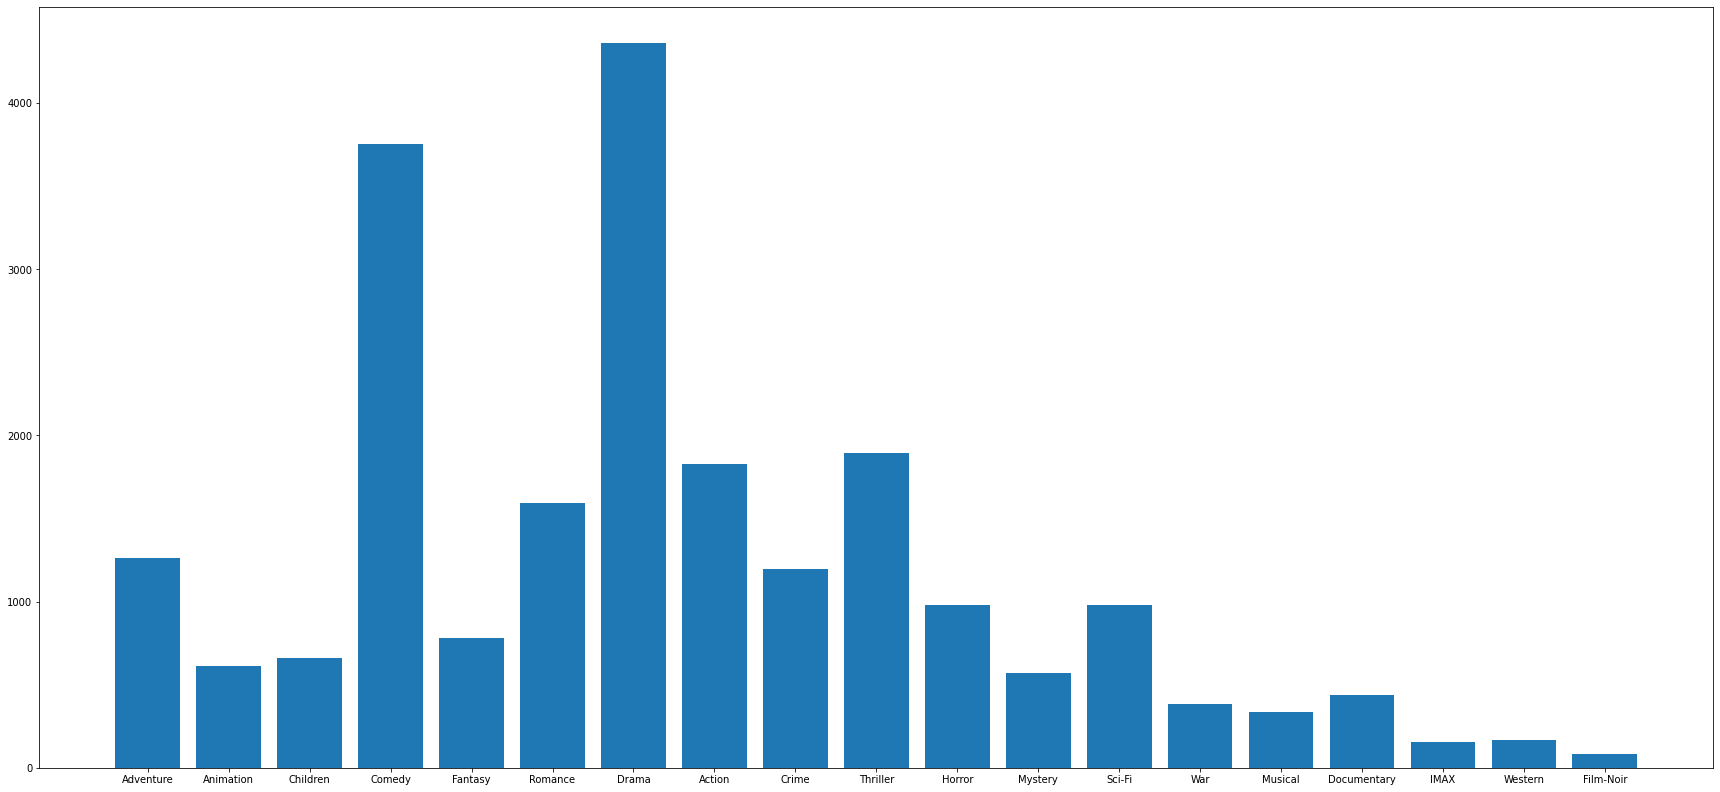

In [6]:
plt.figure(figsize=(30,14))
plt.bar(genres_dict.keys(),genres_dict.values())

In [7]:
display(ratings.info()) # displays general info about the data.
ratings.sample(10) # displays 10 random rows from the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

,userId,movieId,rating,timestamp
61317,402,1036,5.0,849601325
75205,475,364,4.5,1498031570
29298,201,780,4.0,939226691
76112,479,2108,5.0,1039362765
12056,74,1889,5.0,1207501075
69196,448,3448,4.0,1019127559
89152,577,1959,4.0,945978449
91364,592,454,3.0,837353917
84247,539,65,4.5,1332474525
1508,15,7254,3.5,1510572802


In [8]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(ratings.shape)+"\n Movies DataFrame"+ str(movies.shape))

Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


# Content based filtering
We'll use the concept of Term Frequency (TF) and Inverse Document Frequency (IDF), as they are used to determine how important is the movie.
 - Term Frequency (TF):
   - The frequency of the word in a document.
 - Inverse Document Frequency (IDF):
   - inverse of document frequency.

## Why TF-IDF?
Suppose we want to google the word "The Bitcoin Price" as it is obvious, the word "The" has more frequency than the word "Price", but the relative importance of the word "Price" is higher. 
- TF-IDF will help us weighting such things (the relative importance) so that words like (the,or,and, etc) does not affect the importance of other keywords.
- In our project, we will consider genres as our relatively important word to recommend for the user depending on the genre of the movies that the user already watched.

For the distances, we can use many coffeicents to measure the distance, but in our project we'll use **Cosine similarity**


**Cosine similarity** measures the orientation of two n-dimensional sample vectors irrespective to their magnitude. It is calculated by the dot product of two numeric vectors, and it is normalized by the product of the vector lengths, so that output values close to 1 indicate high similarity.

<image src="images/cos_sim.png">


In [9]:
# - 100,000 ratings (1-5) from 943 users on 1682 movies
ratings = pd.read_csv('ratings.csv')

# Movies dataset
movies = pd.read_csv('movies.csv')

In [10]:
# Define a TF-IDF 
tfimovies = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

# empty values replaced with an empty string
movies['genres'] = movies['genres'].replace(to_replace="(no genres listed)", value="")

# Fitting the model [depending on genres]
tfimovies = tfimovies.fit_transform(movies['genres'])

cos_sim = linear_kernel(tfimovies, tfimovies)


In [11]:
def getRecommendationByGenres(movie_title, cos_sim=cos_sim):
    try:
        # Get the index of the movie that matches the title
        indexOfMovie = movies.loc[movies['title'].isin([movie_title])]
        indexOfMovie = indexOfMovie.index
        
        # Get the similarity scores of all movies with that movie
        simillarMovie = list(enumerate(cos_sim[indexOfMovie][0]))
        
        # Sorting the movies based on its scores.
        simillarMovie = sorted(simillarMovie, key=lambda x: x[1], reverse=True)

        simillarMovie = simillarMovie[1:9]
        
        # movie indices
        movie_indices = [i[0] for i in simillarMovie]
        
        # Return the best 8 simillar Movies
        return movies['title'].iloc[movie_indices]
    
    except IndexError:
        print('Error: The movie you entered is not valid, please check the format.')


In [12]:
display(movies['title'].sample(20))
# Note that the film name must be correct and in this form ['Film Name' '(film year)']
userInput= input('Please Enter a movies from the list below to get a recommendation: (or any movie with a valid name) ')
print('Top 8 Movies based on genres are: ')
display(getRecommendationByGenres(userInput))

1659                                     Ring, The (1927)
6690                         Taxi to the Dark Side (2007)
3268    Garden of the Finzi-Continis, The (Giardino de...
7215                                   Crazy Heart (2009)
6220                        Devil Wears Prada, The (2006)
4189                                Darkness Falls (2003)
9631                                     Male Hunt (1964)
388         Farewell My Concubine (Ba wang bie ji) (1993)
7060                              Hurt Locker, The (2008)
6817                             Pineapple Express (2008)
7190                                Messenger, The (2009)
3874                            Rabbit-Proof Fence (2002)
1772                           Emerald Forest, The (1985)
1265                                 Sliding Doors (1998)
5409    Boudu Saved From Drowning (Boudu sauvé des eau...
5270                                      Catwoman (2004)
9512                                      The Hero (2017)
7665          

Top 8 Movies based on genres are: 
Error: The movie you entered is not valid, please check the format.


None

In [13]:
def getRecommendationByUserID(userId):

    recommended = []
    movieList = []

    for key, row in ratings[ratings["userId"]== userId].iterrows():
        movieList.append((movies["title"][row["movieId"]==movies["movieId"]]).values) 
    for index, movie in enumerate(movieList):
        for key, movieRecommended in getRecommendationByGenres(movie[0]).iteritems():
            recommended.append(movieRecommended)

    # removing already watched movie from recommended list    
    for title in recommended:
        if title in movieList:
            recommended.remove(title)
    
    return recommended
userId = int(input('Enter your user ID to get recommendations: '))
print(f' Top 10 recommended movies for UserID {userId} is \n {getRecommendationByUserID(userId)[:10]}')

 Top 10 recommended movies for UserID 10 is 
 ['Fargo (1996)', 'Freeway (1996)', "Man Bites Dog (C'est arrivé près de chez vous) (1992)", 'Beautiful Creatures (2000)', 'Confessions of a Dangerous Mind (2002)', 'Party Monster (2003)', 'In Bruges (2008)', 'Informant!, The (2009)', 'Life Is Beautiful (La Vita è bella) (1997)', 'Train of Life (Train de vie) (1998)']


# Model Validation with KNN
To check weather we got an accurate recommendations, we'll use KNeighborsClassifier.


In [14]:
from sklearn.neighbors import KNeighborsClassifier 
 
def moviePredicts(movieID):

    classifier = KNeighborsClassifier(n_neighbors=5)
    x =  tfimovies
    
    y = movies.iloc[:,-1]
    
    classifier.fit(x, y)
    
    y_pred = classifier.predict(tfimovies[movieID])
    
    # Return the predicted Values
    return y_pred

In [15]:
true = 0
false = 0


def validateModel():

    for key, columns in movies.iterrows():

        moviesFromModel = getRecommendationByGenres(columns["title"])

        predicts = moviePredicts(moviesFromModel.index)
        for predictedGenre in predicts:
            global true, false
            if predictedGenre == columns["genres"]:
                true = true + 1
            else:
                false = false + 1


validateModel()
total = true + false

HIT = true / total
FAULT = false / total

print(f'Hit:   {HIT}')
print(f'Fault: {FAULT}')


Hit:   0.8908976596181483
Fault: 0.10910234038185178


# Collaborative Filtering
> - it uses the similarities between users and items to provide recommendations

Types of collaborative filtering techniques
- **Memory based** 
  - User-Item Filtering
  - Item-Item Filtering
- **Model based** 
  - Matrix Factorization
  - Clustering
  - Deep Learning

> Re-Reading the data.

In [16]:
# This dataset has the following:
# - 100,000 ratings (1-5) from 943 users on 1682 movies
ratings = pd.read_csv('ratings.csv')

# Movies dataset
movies = pd.read_csv('movies.csv')

dfRatings = ratings
dfMovies = movies

# Memory based
> For our project, we'll use Memory Based approach only.
## item-item Filtering
- it recommends based on the similarity between items calculated using others' ratings on these items.

In [17]:
dfMerged=pd.merge(dfMovies, dfRatings)
display(dfMerged)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [18]:
# The pivot table will navigate (map) between the movies and users and their ratings.
matrix = dfMerged.pivot_table(index=['movieId'], columns=[
                              'userId'], values='rating').reset_index(drop=True)
matrix.fillna(0, inplace=True)
display(matrix)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [20]:

similarity = 1 - pairwise_distances(matrix.to_numpy() , metric="cosine")
np.fill_diagonal(similarity, 0)
matrix = pd.DataFrame(similarity)
matrix


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


This function takes the movie's name as an input, and then will find the movies that are similar to the movie, it first find the index of the movie in the movies dataset, then searches for similarity and align it in the movies dataset. 

In [21]:
def item_similarity(movieName): 
    try:
        user_Index=movieName
        Index=dfMovies[dfMovies['title']==user_Index].index.tolist()
        Index=Index[0]

        dfMovies['similarity'] = matrix.iloc[Index]
        dfMovies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [22]:
def recommendWithItemSimillarty(user_id):

    user_movie = dfMerged[(dfMerged.userId == user_id) &
                          dfMerged.rating.isin([5, 4.5])][['title']]

    user_movie = user_movie.iloc[0, 0]
    item_similarity(user_movie)
    sortPerUserChoice = dfMovies.sort_values(
        ["similarity"], ascending=False)
    
    sortPerUserChoice = sortPerUserChoice[
        sortPerUserChoice['similarity'] >= 0.45]['movie_id']
    
    df_recommended_item = pd.DataFrame()
    
    userToMovies = dfRatings[dfRatings['userId'] == user_id]['movieId']
    
    for movieId in sortPerUserChoice:
        if movieId not in userToMovies:
            df_new = dfRatings[(dfRatings.movieId == movieId)]
            
            df_recommended_item = pd.concat([df_recommended_item, df_new])
            
        bestMovies = df_recommended_item.sort_values(
            ["rating"], ascending=False)[1:10]
        
    return bestMovies['movieId']


In [23]:
def movieIdToTitle(listMovieIDs):

    titles = []
    for id in listMovieIDs:
        titles.append(movies[movies['movie_id'] == id]['title'])
    return titles


In [24]:
# user_id= int(input('Please Enter User ID to get top 10 recommendations: '))
# print("Recommended movies,:\n",movieIdToTitle(recommendWithItemSimillarty(user_id)))
# print(type(movieIdToTitle(recommendWithItemSimillarty(user_id))))

## User-Item Filtering
To illustrate the idea of User-Item Filtering, consider two persons, A and B, person A loves [Salad - Pizza], person B loves [Pizza-Salad-**Cola**]. Person A and Person B has similar favorite food [Pizza-Salad], so what remains for person B is the **Cola**, so we'll recommend cola for person B.

![alt text](https://cdn-images-1.medium.com/max/1500/0*o0zVW2O6Rv-LI5Mu.png)



> Same As Item-Item similarity we will create a matrix but here we will keep rows as user and columns as movieId as we want a vector of different users.
Then we'll do the same for the distances.

In [25]:
nMatrix = dfMerged.pivot_table(index=['userId'], columns=[
                               'movieId'], values='rating').reset_index(drop=True)
nMatrix.fillna(0, inplace=True)
movie_similarity = 1 - pairwise_distances(nMatrix.to_numpy(), metric="cosine")
np.fill_diagonal(movie_similarity, 0)
nMatrix = pd.DataFrame(movie_similarity)
nMatrix


,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


In [26]:
display(nMatrix.idxmax(axis=1))  # this will return first occurance
display(nMatrix.idxmax(axis=1).sample(10)) # sample
 
dfSameUsers= nMatrix.idxmax(axis=1).to_frame() 


0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

227    493
608    339
606    569
266    493
301    205
234     37
518    412
305    110
228    234
421    136
dtype: int64

In [27]:
dfSameUsers.columns=['similarUser']
dfSameUsers

,similarUser
0,265
1,365
2,312
3,390
4,469
...,...
605,473
606,569
607,479
608,339


The function below will do the following:
 > - takes the used id as an input
 > - Searches for a user with similar movies [Person A - Person B]
 > - then we filter the movies that are highly rated by user B and recommend it for A.
 

In [28]:
movieId_recommended = list()


def getRecommendationByUserSimilar(userId):


    userToMovies = dfRatings[dfRatings['userId'] == userId]['movieId']
    sim_user = dfSameUsers.iloc[0, 0]
    
    
    df_recommended = pd.DataFrame(
        columns=['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'])
    
    for movieId in dfRatings[dfRatings['userId'] == sim_user]['movieId']:
        if movieId not in userToMovies:
            newDF = dfMerged[(dfMerged.userId == sim_user) & (
                dfMerged.movieId == movieId)]
            
            df_recommended = pd.concat([df_recommended, newDF])
        BestMovies = df_recommended.sort_values(
            ['rating'], ascending=False)[1:10]
        
    return BestMovies['movieId']


In [29]:
# user_id = int(input("Enter your user ID [from 1 to 610] "))
# movies= movieIdToTitle(getRecommendationByUserSimilar(user_id))
# print("Movies you should watch based on other users:")
# print(movies)

In [30]:
# ratings = pd.read_csv('ratings.csv')
# movies = pd.read_csv('movies.csv')

# dfRatings = ratings
# dfMovies = movies
# dfMerged=pd.merge(dfMovies, dfRatings)


In [51]:
import tkinter as tk
from tkinter import *
from tkinter import ttk
import tkinter.messagebox
from PIL import ImageTk, Image  


window = tk.Tk()
window.geometry("850x400")

    
def contentBasedInput():
    try:
        ID = entry.get()
        listOfFilms = getRecommendationByGenres(ID).tolist()
        tkinter.messagebox.showinfo("Your list of  Films is: ",  listOfFilms)
    except Exception:
        tkinter.messagebox.showinfo("Movie's name isn't valid")
         
    
def itemBasedInput():
    ID = entry.get()
    listOfFilms = movieIdToTitle(recommendWithItemSimillarty(int(ID)))
    tkinter.messagebox.showinfo("Your list of  Films is: ",  listOfFilms)
    
    
    
def UseritemBasedInput():
    ID = entry.get()
    listOfFilms = movieIdToTitle(getRecommendationByUserSimilar(int(ID)))
    tkinter.messagebox.showinfo("Your list of  Films is: ",  listOfFilms)

def content_based():
    window.destroy()
    window1 = tk.Tk()
    window1.geometry("650x250")
    page1textCb = tk.Label(window1, text="Please enter the film's name to start \n (Film Name) (Year), e.g. Selma (2014)",
                           font=("Arial", 12))
    page1textCb.pack()
    global entry
    entry = tk.Entry(window1, fg="black", bg="white", width=25)
    entry.pack()

    button = ttk.Button(window1, text="Okay", width=25, command=contentBasedInput)
    button.pack()
    
def collaborative():
    window.destroy()
    window1 = tk.Tk()
    window1.geometry("650x250")
    page1textCb = tk.Label(window1, text="Please Enter your user ID [1-610]",
                           font=("Arial", 12))
    page1textCb.pack()
    global entry
    entry = tk.Entry(window1, fg="black", bg="white", width=25)
    entry.pack()

    button = ttk.Button(window1, text="Item Based", width=25, command=itemBasedInput)
    button2 = ttk.Button(window1, text="User Based", width=25, command=UseritemBasedInput)
    button.pack()    
    button2.pack()
    
def itemBasedInput():
    ID = entry.get()
    listOfFilms = movieIdToTitle(recommendWithItemSimillarty(int(ID)))
    tkinter.messagebox.showinfo("Your list of  Films is: ",  listOfFilms)
    
    
    
def UseritemBasedInput():
    ID = entry.get()
    listOfFilms = movieIdToTitle(getRecommendationByUserSimilar(int(ID)))
    tkinter.messagebox.showinfo("Your list of  Films is: ",  listOfFilms)    


   
   
window = tk.Tk()
window.geometry("850x400") 

    


label_1 = tk.Label(
    window,
    text="ICS574 Project, please select what type of filtering you want:  ",
    fg="black",
    font=("Arial", 12)
)
label_1.pack()


ttk.Button(window, text="Content-Based Filtering", width=25, command=content_based).pack(pady=20)
ttk.Button(window, text="Collaborative Filtering", width=25, command=collaborative).pack(pady=20)
img = ImageTk.PhotoImage(Image.open("images/kfupm-logo.png"),size = 20)
panel = Label(window, image = img)   
panel.pack(side = "bottom", fill = "both", expand = "no")


# runs the GUI
window.mainloop()


In [52]:
getRecommendationByGenres('Scooby-Doo (2002)').tolist()


['Holes (2003)',
 'Scooby-Doo! Curse of the Lake Monster (2010)',
 'Borrowers, The (1997)',
 "Lemony Snicket's A Series of Unfortunate Events (2004)",
 'Son of the Mask (2005)',
 'Asterix & Obelix vs. Caesar (Astérix et Obélix contre César) (1999)',
 'Casper Meets Wendy (1998)',
 'Shaggy Dog, The (2006)']